# 🧪 Laboratorium 6 — Integracja technik przetwarzania obrazów

## Cel ćwiczenia
Celem laboratorium jest integracja poznanych metod przetwarzania obrazów:
- analizy histogramów,
- filtracji i redukcji szumów,
- segmentacji (progowanie globalne, Otsu, adaptacyjne),
- detekcji krawędzi (Sobel, Laplace, Canny),
- oraz analizy konturów i kształtów obiektów.

Efektem końcowym jest stworzenie kompletnego pipeline’u analizy obrazu — od wczytania do klasyfikacji kształtów.


📚 Sekcja 2 – Biblioteki i funkcje pomocnicze

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def show_images(imgs, titles, cmap=None, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap=cmap)
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


🖼️ Sekcja 3 – Wczytanie i analiza obrazu

## 1. Wczytanie obrazu i analiza histogramu


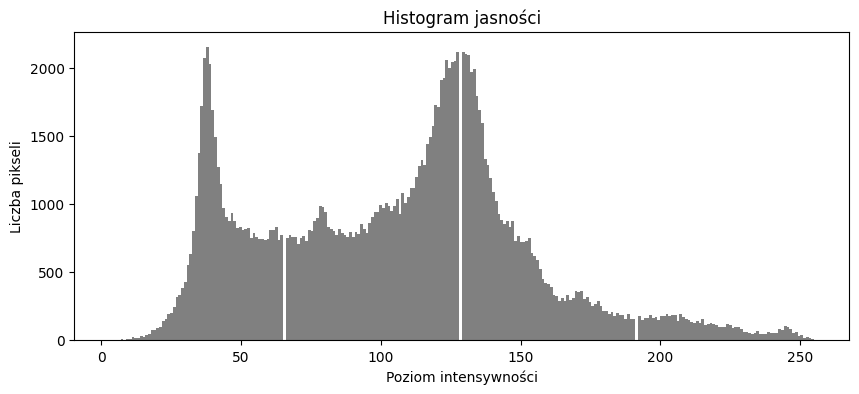

In [2]:

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"

obraz=obraz1

image = cv2.imread(obraz)
if image is None:
    raise FileNotFoundError("Nie znaleziono pliku 4s.png — upewnij się, że jest w katalogu roboczym.")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,4))
plt.hist(gray.ravel(), bins=256, color='gray')
plt.title('Histogram jasności')
plt.xlabel('Poziom intensywności')
plt.ylabel('Liczba pikseli')
plt.show()


🎛️ Sekcja 4 – Poprawa kontrastu (Histogram Equalization i Stretching)

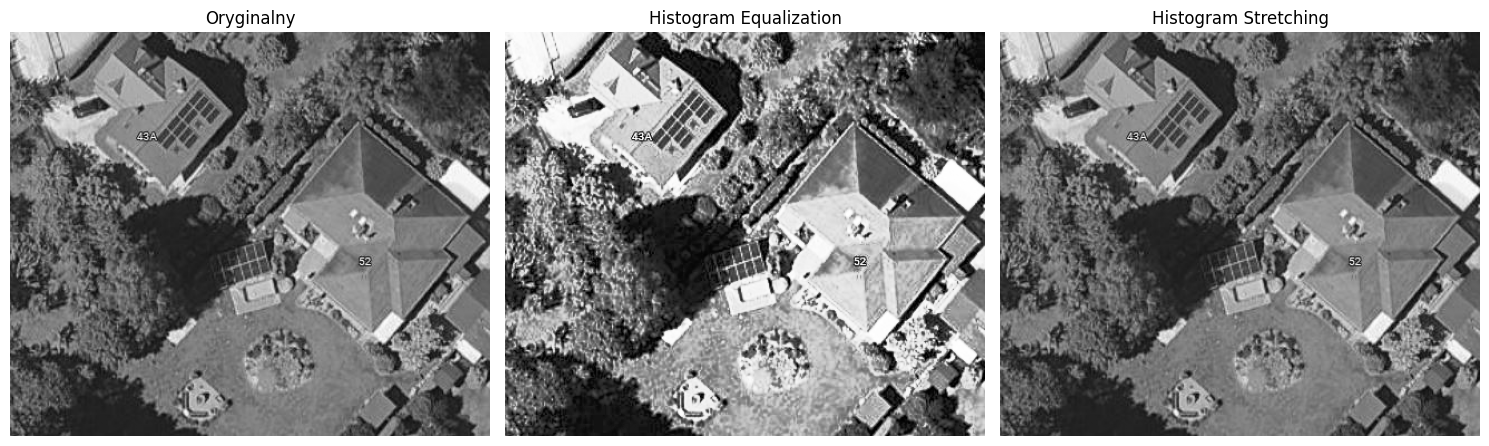

In [3]:
eq = cv2.equalizeHist(gray)
stretch = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

show_images([gray, eq, stretch],
            ["Oryginalny", "Histogram Equalization", "Histogram Stretching"], cmap='gray')


🧹 Sekcja 5 – Filtracja obrazu (redukcja szumów)

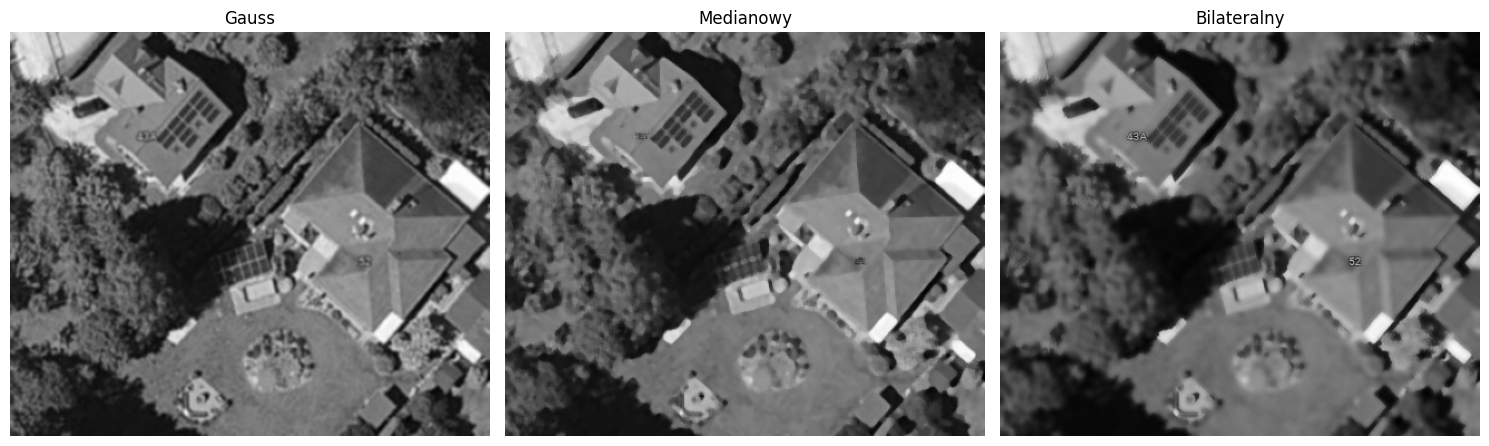

Gauss: PSNR=27.74, SSIM=0.873
Medianowy: PSNR=25.21, SSIM=0.751
Bilateralny: PSNR=24.52, SSIM=0.660


In [4]:
gauss = cv2.GaussianBlur(gray, (5,5), 0)
median = cv2.medianBlur(gray, 5)
bilateral = cv2.bilateralFilter(gray, 9, 75, 75)

show_images([gauss, median, bilateral], ["Gauss", "Medianowy", "Bilateralny"], cmap='gray')

def compare_metrics(original, filtered):
    p = psnr(original, filtered)
    s = ssim(original, filtered)
    return p, s

for name, img in zip(["Gauss", "Medianowy", "Bilateralny"], [gauss, median, bilateral]):
    p, s = compare_metrics(gray, img)
    print(f"{name}: PSNR={p:.2f}, SSIM={s:.3f}")


🧭 Sekcja 6 – Segmentacja (Globalna, Otsu, Adaptacyjna)

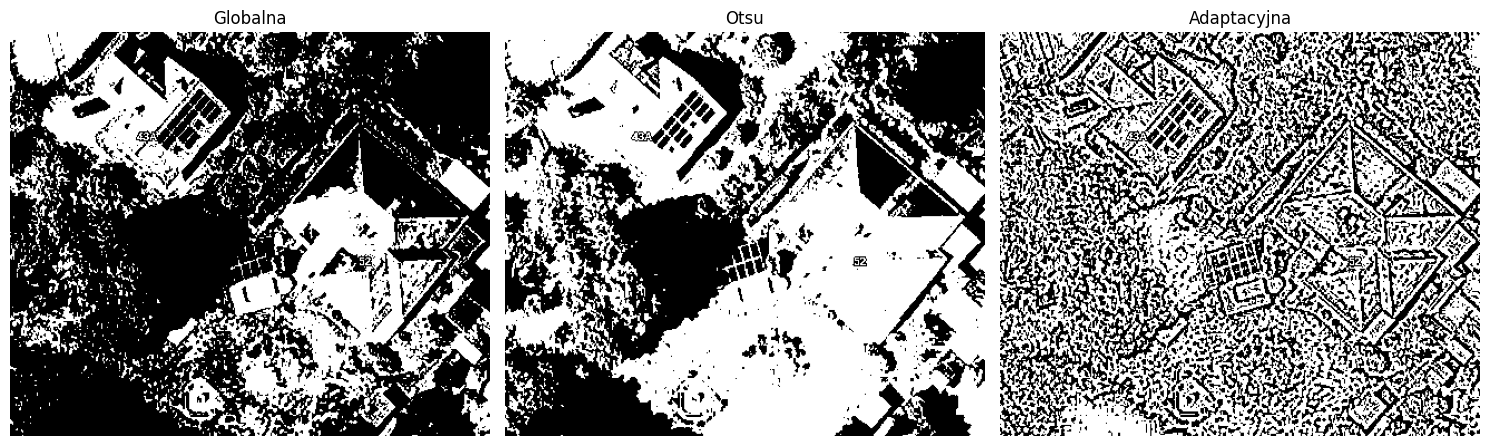

In [5]:
_, global_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
_, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

show_images([global_thresh, otsu_thresh, adaptive],
            ["Globalna", "Otsu", "Adaptacyjna"], cmap='gray')


📈 Sekcja 7 – Metryki jakości segmentacji (IoU, Dice)

In [6]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

def dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2*np.sum(intersection) / (np.sum(mask1) + np.sum(mask2))

ref = otsu_thresh > 0
print("Porównanie masek:")
for name, m in zip(["Globalna", "Adaptacyjna"], [global_thresh>0, adaptive>0]):
    print(f"{name}: IoU={iou(ref,m):.3f}, Dice={dice(ref,m):.3f}")


Porównanie masek:
Globalna: IoU=0.574, Dice=0.730
Adaptacyjna: IoU=0.570, Dice=0.726


⚡ Sekcja 8 – Wykrywanie krawędzi (Sobel, Laplace, Canny)

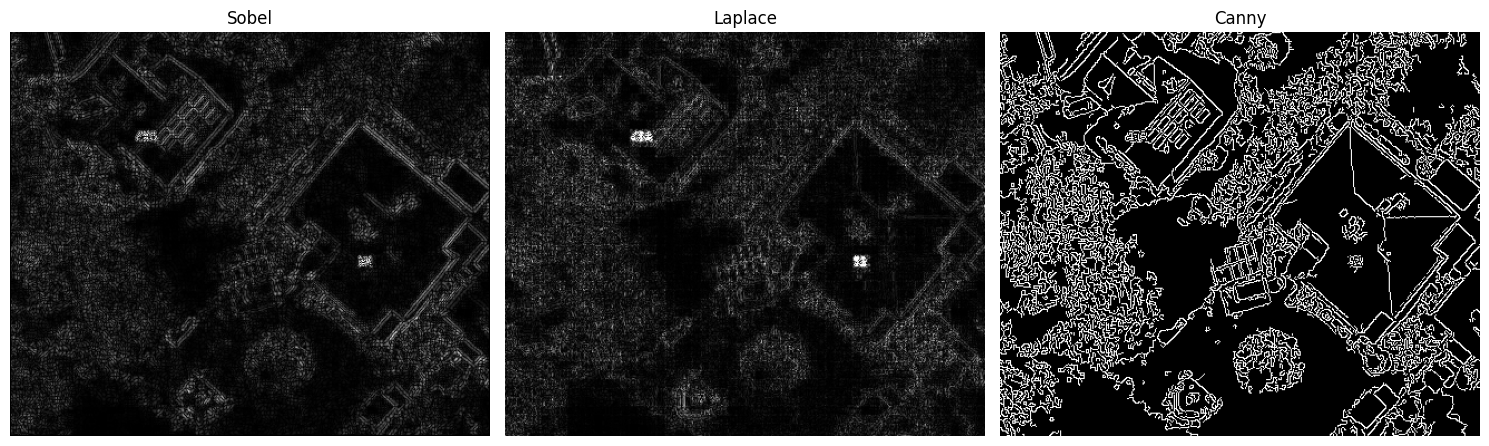

In [7]:
sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)
sobel = cv2.convertScaleAbs(sobel)
laplace = cv2.Laplacian(gray, cv2.CV_64F)
laplace = cv2.convertScaleAbs(laplace)
canny = cv2.Canny(gray, 100, 200)

show_images([sobel, laplace, canny], ["Sobel", "Laplace", "Canny"], cmap='gray')


🔷 Sekcja 9 – Analiza konturów i kształtów

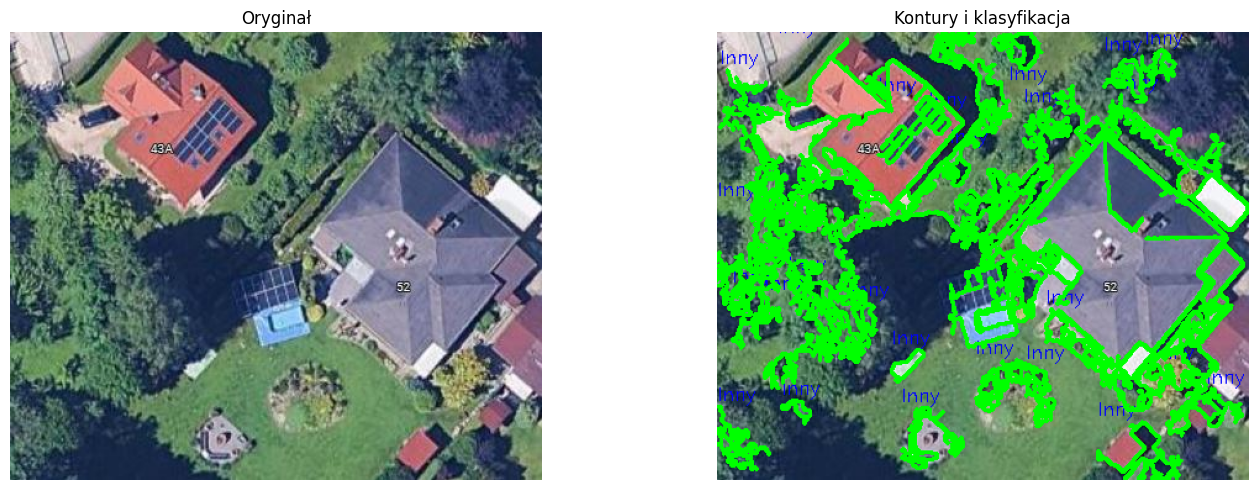

In [8]:
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = image.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area < 100:
        continue
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * area / (perimeter ** 2)
    cv2.drawContours(img_contours, [c], -1, (0, 255, 0), 2)
    x, y, w, h = cv2.boundingRect(c)
    label = "Koło" if circularity > 0.8 else "Inny"
    cv2.putText(img_contours, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

show_images([image, img_contours], ["Oryginał", "Kontury i klasyfikacja"])


🔗 Sekcja 10 – Integracja etapów w pipeline

## 10. Integracja etapów przetwarzania
Zintegrowany przepływ:
1. Filtracja (redukcja szumów)
2. Segmentacja
3. Detekcja krawędzi
4. Analiza konturów


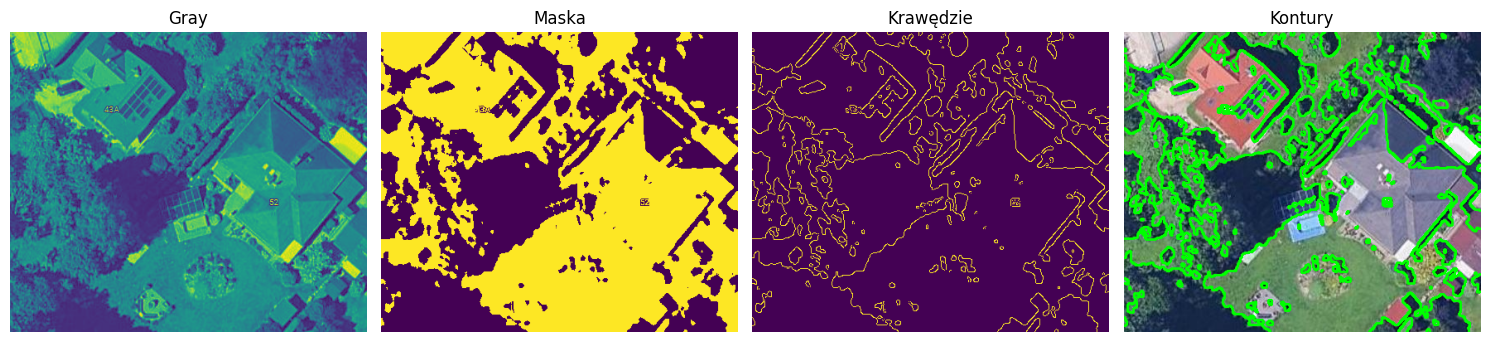

In [9]:
pipeline = cv2.bilateralFilter(gray, 9, 75, 75)
_, mask = cv2.threshold(pipeline, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edges = cv2.Canny(mask, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
out = image.copy()
cv2.drawContours(out, contours, -1, (0,255,0), 2)
show_images([gray, mask, edges, out], ["Gray", "Maska", "Krawędzie", "Kontury"])


🧠 Sekcja 11 – Zadania do samodzielnego wykonania

## 11. Zadania do samodzielnego wykonania
1. Zastosuj filtr medianowy przed segmentacją i porównaj wynik IoU.
2. Zbadaj wpływ wartości progów Canny (dolny, górny) na wynik.
3. Spróbuj wykryć kształty elips i prostokątów osobno.
4. Porównaj histogramy po filtracji Gaussa i bilateralnej.
5. Oblicz średnią wartość SSIM między maską Otsu a adaptacyjną.
6. Rozszerz pipeline o detekcję kolorowych obiektów (HSV).
7. Zapisz wyniki etapów przetwarzania do pliku PDF.
8. Użyj innego obrazu testowego i oceń stabilność algorytmów.
9. Zmierz czas wykonania poszczególnych etapów.
10. Opracuj automatyczny pipeline z parametrami wejściowymi użytkownika.
